In [1]:
import gc
import osgc
import time
import logging
import datetime
import warnings
import numpy as np
from pyentrp import entropy as ent
from pathlib import Path
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KDTree
import pywt
from scipy import stats
from scipy import signal
from scipy.signal import butter, deconvolve
from scipy.signal import hann
from scipy.signal import periodogram
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
# from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNet
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")
from tsfresh.feature_extraction import feature_calculators
from pyentrp import entropy as ent

In [2]:
# Lets go ahead  and have a look at data
DATA_PATH = "C:/Users/flemeill/OneDrive - Capgemini/04 - Kaggles/02 - Earthquakes/01 - Data/"  
Res_Path = "C:/Users/flemeill/OneDrive - Capgemini/04 - Kaggles/02 - Earthquakes/03 - Résultats/" 
Test_Path = "C:/Users/flemeill/OneDrive - Capgemini/04 - Kaggles/02 - Earthquakes/01 - Data/test/"  
train = pd.read_csv(str(Path(DATA_PATH) / "train.csv"), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}, 
                   low_memory=True)

## Denoising

In [3]:
from numba import jit

In [4]:
SIGNAL_LEN = 150000
SAMPLE_RATE = 4000
def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def high_pass_filter(x, low_cutoff=10, SAMPLE_RATE=SAMPLE_RATE):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * SAMPLE_RATE
    norm_low_cutoff = low_cutoff / nyquist
    
    # Fault pattern usually exists in high frequency band. According to literature, the pattern is visible above 10^4 Hz.
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

def denoise_signal(x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest(coeff[-level])

    # Calculate the univeral threshold
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

## Feature

In [6]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [7]:
def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

In [8]:
def calc_change_rate1000(x):
    change = (np.diff(x, 1000) / x[:-1000]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

In [9]:
def calRCS(data):
    N = len(data)
    m = np.mean(data)
    sigma = np.std(data)
    s = np.cumsum(data-m) * 1.0 / (N * sigma)
    R = np.max(s) - np.min(s)
    return R

In [10]:
def flatiron(x, alpha=100., beta=1):
    """
    Flatten signal
    
    Creator: Michael Kazachok
    Source: https://www.kaggle.com/miklgr500/flatiron
    """
    new_x = np.zeros_like(x)
    zero = x[0]
    for i in range(1, len(x)):
        zero = zero*(alpha-beta)/alpha + beta*x[i]/alpha
        new_x[i] = x[i] - zero
    return new_x
def drop_missing(intersect,sample):
    """
    Find intersection of sorted numpy arrays
    
    Since intersect1d sort arrays each time, it's effectively inefficient.
    Here you have to sweep intersection and each sample together to build
    the new intersection, which can be done in linear time, maintaining order. 

    Source: https://stackoverflow.com/questions/46572308/intersection-of-sorted-numpy-arrays
    Creator: B. M.
    """
    i=j=k=0
    new_intersect=np.empty_like(intersect)
    while i< intersect.size and j < sample.size:
        if intersect[i]==sample[j]: # the 99% case
            new_intersect[k]=intersect[i]
            k+=1
            i+=1
            j+=1
        elif intersect[i]<sample[j]:
            i+=1
        else : 
            j+=1
    return new_intersect[:k]
def _local_maxima_1d_window_single_pass(x, w):
    
    midpoints = np.empty(x.shape[0] // 2, dtype=np.intp)
    left_edges = np.empty(x.shape[0] // 2, dtype=np.intp)
    right_edges = np.empty(x.shape[0] // 2, dtype=np.intp)
    m = 0  # Pointer to the end of valid area in allocated arrays

    i = 1  # Pointer to current sample, first one can't be maxima
    i_max = x.shape[0] - 1  # Last sample can't be maxima
    while i < i_max:
        # Test if previous sample is smaller
        if x[i - 1] < x[i]:
            i_ahead = i + 1  # Index to look ahead of current sample

            # Find next sample that is unequal to x[i]
            while i_ahead < i_max and x[i_ahead] == x[i]:
                i_ahead += 1
                    
            i_right = i_ahead - 1
            
            f = False
            i_window_end = i_right + w
            while i_ahead < i_max and i_ahead < i_window_end:
                if x[i_ahead] > x[i]:
                    f = True
                    break
                i_ahead += 1
                
            # Maxima is found if next unequal sample is smaller than x[i]
            if x[i_ahead] < x[i]:
                left_edges[m] = i
                right_edges[m] = i_right
                midpoints[m] = (left_edges[m] + right_edges[m]) // 2
                m += 1
                
            # Skip samples that can't be maximum
            i = i_ahead - 1
        i += 1

    # Keep only valid part of array memory.
    midpoints = midpoints[:m]
    left_edges = left_edges[:m]
    right_edges = right_edges[:m]
    
    return midpoints, left_edges, right_edges
def local_maxima_1d_window(x, w=1):
    """
    Find local maxima in a 1D array.
    This function finds all local maxima in a 1D array and returns the indices
    for their midpoints (rounded down for even plateau sizes).
    It is a modified version of scipy.signal._peak_finding_utils._local_maxima_1d
    to include the use of a window to define how many points on each side to use in
    the test for a point being a local maxima.
    Parameters
    ----------
    x : ndarray
        The array to search for local maxima.
    w : np.int
        How many points on each side to use for the comparison to be True
    Returns
    -------
    midpoints : ndarray
        Indices of midpoints of local maxima in `x`.
    Notes
    -----
    - Compared to `argrelmax` this function is significantly faster and can
      detect maxima that are more than one sample wide. However this comes at
      the cost of being only applicable to 1D arrays.
    """    
        
    fm, fl, fr = _local_maxima_1d_window_single_pass(x, w)
    bm, bl, br = _local_maxima_1d_window_single_pass(x[::-1], w)
    bm = np.abs(bm - x.shape[0] + 1)[::-1]
    bl = np.abs(bl - x.shape[0] + 1)[::-1]
    br = np.abs(br - x.shape[0] + 1)[::-1]

    m = drop_missing(fm, bm)

    return m
def get_peaks(
    x, 
    window=25,
    visualise=False,
    visualise_color=None,):
    """
    Find the peaks in a signal trace.
    Parameters
    ----------
    x : ndarray
        The array to search.
    window : np.int
        How many points on each side to use for the local maxima test
    Returns
    -------
    peaks_x : ndarray
        Indices of midpoints of peaks in `x`.
    peaks_y : ndarray
        Absolute heights of peaks in `x`.
    x_hp : ndarray
        An absolute flattened version of `x`.
    """
    
    x_hp = flatiron(x, 100, 1)

    x_dn = np.abs(x_hp)
    
    peaks = local_maxima_1d_window(x_dn, window)
    
    heights = x_dn[peaks]
    
    ii = np.argsort(heights)[::-1]
    
    peaks = peaks[ii]
    heights = heights[ii]
    
    ky = heights
    kx = np.arange(1, heights.shape[0]+1)
    
    conv_length = 9

    grad = np.diff(ky, 1)/np.diff(kx, 1)
    grad = np.convolve(grad, np.ones(conv_length)/conv_length)#, mode='valid')
    grad = grad[conv_length-1:-conv_length+1]
    
    knee_x = plateau_detection(grad, -0.01, plateau_length=1000)
    knee_x -= conv_length//2
    
    if visualise:
        plt.plot(grad, color=visualise_color)
        plt.axvline(knee_x, ls="--", color=visualise_color)
    
    peaks_x = peaks[:knee_x]
    peaks_y = heights[:knee_x]
    
    ii = np.argsort(peaks_x)
    peaks_x = peaks_x[ii]
    peaks_y = peaks_y[ii]
        
    return peaks_x, peaks_y, x_hp

In [11]:
def katz_fd(x):
    """Katz Fractal Dimension.
    Parameters
    ----------
    x : list or np.array
        One dimensional time series
    Returns
    -------
    kfd : float
        Katz fractal dimension
    Notes
    -----
    The Katz Fractal dimension is defined by:
    .. math:: FD_{Katz} = \dfrac{log_{10}(n)}{log_{10}(d/L)+log_{10}(n)}
    where :math:`L` is the total length of the time series and :math:`d`
    is the Euclidean distance between the first point in the
    series and the point that provides the furthest distance
    with respect to the first point.
    Original code from the mne-features package by Jean-Baptiste Schiratti
    and Alexandre Gramfort.
    References
    ----------
    .. [1] Esteller, R. et al. (2001). A comparison of waveform fractal
           dimension algorithms. IEEE Transactions on Circuits and Systems I:
           Fundamental Theory and Applications, 48(2), 177-183.
    .. [2] Goh, Cindy, et al. "Comparison of fractal dimension algorithms for
           the computation of EEG biomarkers for dementia." 2nd International
           Conference on Computational Intelligence in Medicine and Healthcare
           (CIMED2005). 2005.
    Examples
    --------
    Katz fractal dimension.
        >>> import numpy as np
        >>> from entropy import katz_fd
        >>> np.random.seed(123)
        >>> x = np.random.rand(100)
        >>> print(katz_fd(x))
            5.1214
    """
    x = np.array(x)
    dists = np.abs(np.ediff1d(x))
    ll = dists.sum()
    ln = np.log10(np.divide(ll, dists.mean()))
    aux_d = x - x[0]
    d = np.max(np.abs(aux_d[1:]))
    return np.divide(ln, np.add(ln, np.log10(np.divide(d, ll))))

In [12]:
@jit('float64(float64[:], int32)')
def _higuchi_fd(x, kmax):
    """Utility function for `higuchi_fd`.
    """
    n_times = x.size
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    for k in range(1, kmax + 1):
        lm = np.empty((k,))
        for m in range(k):
            ll = 0
            n_max = floor((n_times - m - 1) / k)
            n_max = int(n_max)
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])
            ll /= k
            ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
        # Mean of lm
        m_lm = 0
        for m in range(k):
            m_lm += lm[m]
        m_lm /= k
        lk[k - 1] = m_lm
        x_reg[k - 1] = log(1. / k)
        y_reg[k - 1] = log(m_lm)
    higuchi, _ = _linear_regression(x_reg, y_reg)
    return higuchi

def higuchi_fd(x, kmax=10):
    """Higuchi Fractal Dimension.
    Parameters
    ----------
    x : list or np.array
        One dimensional time series
    kmax : int
        Maximum delay/offset (in number of samples).
    Returns
    -------
    hfd : float
        Higuchi Fractal Dimension
    Notes
    -----
    Original code from the mne-features package by Jean-Baptiste Schiratti
    and Alexandre Gramfort.
    The `higuchi_fd` function uses Numba to speed up the computation.
    References
    ----------
    .. [1] Higuchi, Tomoyuki. "Approach to an irregular time series on the
       basis of the fractal theory." Physica D: Nonlinear Phenomena 31.2
       (1988): 277-283.
    Examples
    --------
    Higuchi Fractal Dimension
        >>> import numpy as np
        >>> from entropy import higuchi_fd
        >>> np.random.seed(123)
        >>> x = np.random.rand(100)
        >>> print(higuchi_fd(x))
            2.051179
    """
    x = np.asarray(x, dtype=np.float64)
    kmax = int(kmax)
    return _higuchi_fd(x, kmax)

In [14]:
# higuchi_fd(seg['acoustic_data'].values, 10)

In [15]:
# def min_max_transfer(ts, min_value, max_value, range_needed=(-1,1)):
#     ts_std = (ts - min_value) / (max_value - min_value)

#     if range_needed[0] < 0:    
#         return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
#     else:
#         return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]
    
    
# def transform_ts(ts, n_dim=160, min_max=(-1,1)):
#     ts_std = min_max_transfer(ts, min_value=MIN_NUM, max_value=MAX_NUM)
#     bucket_size = int(SIGNAL_LEN / n_dim)
#     new_ts = []
#     for i in range(0, SIGNAL_LEN, bucket_size):
#         ts_range = ts_std[i:i + bucket_size]
#         mean = ts_range.mean()
#         std = ts_range.std()
#         std_top = mean + std
#         std_bot = mean - std
#         percentil_calc = ts_range.quantile([0, 0.01, 0.25, 0.50, 0.75, 0.99, 1])
#         max_range = ts_range.quantile(1) - ts_range.quantile(0)
#         relative_percentile = percentil_calc - mean
#         new_ts.append(np.concatenate([np.asarray([mean, std, std_top, std_bot, max_range]), percentil_calc, relative_percentile]))
#     return np.asarray(new_ts)

In [16]:
# def spectral_entropy(x, sf, method='fft', nperseg=None, normalize=False):
#     """Spectral Entropy.
#     Parameters
#     ----------
#     x : list or np.array
#         One-dimensional time series of shape (n_times)
#     sf : float
#         Sampling frequency
#     method : str
#         Spectral estimation method ::
#         'fft' : Fourier Transform (via scipy.signal.periodogram)
#         'welch' : Welch periodogram (via scipy.signal.welch)
#     nperseg : str or int
#         Length of each FFT segment for Welch method.
#         If None, uses scipy default of 256 samples.
#     normalize : bool
#         If True, divide by log2(psd.size) to normalize the spectral entropy
#         between 0 and 1. Otherwise, return the spectral entropy in bit.
#     Returns
#     -------
#     se : float
#         Spectral Entropy
#     Notes
#     -----
#     Spectral Entropy is defined to be the Shannon Entropy of the Power
#     Spectral Density (PSD) of the data:
#     .. math:: H(x, sf) =  -\\sum_{f=0}^{f_s/2} PSD(f) log_2[PSD(f)]
#     Where :math:`PSD` is the normalised PSD, and :math:`f_s` is the sampling
#     frequency.
#     References
#     ----------
#     .. [1] Inouye, T. et al. (1991). Quantification of EEG irregularity by
#        use of the entropy of the power spectrum. Electroencephalography
#        and clinical neurophysiology, 79(3), 204-210.
#     Examples
#     --------
#     1. Spectral entropy of a pure sine using FFT
#         >>> from entropy import spectral_entropy
#         >>> import numpy as np
#         >>> sf, f, dur = 100, 1, 4
#         >>> N = sf * duration # Total number of discrete samples
#         >>> t = np.arange(N) / sf # Time vector
#         >>> x = np.sin(2 * np.pi * f * t)
#         >>> print(np.round(spectral_entropy(x, sf, method='fft'), 2)
#             0.0
#     2. Spectral entropy of a random signal using Welch's method
#         >>> from entropy import spectral_entropy
#         >>> import numpy as np
#         >>> np.random.seed(42)
#         >>> x = np.random.rand(3000)
#         >>> print(spectral_entropy(x, sf=100, method='welch'))
#             9.939
#     3. Normalized spectral entropy
#         >>> print(spectral_entropy(x, sf=100, method='welch', normalize=True))
#             0.995
#     """
#     x = np.array(x)
#     # Compute and normalize power spectrum
#     if method == 'fft':
#         _, psd = periodogram(x, sf)
#     elif method == 'welch':
#         _, psd = welch(x, sf, nperseg=nperseg)
#     psd_norm = np.divide(psd, psd.sum())
#     se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
#     if normalize:
#         se /= np.log2(psd_norm.size)
#     return se

In [17]:
# def _numba_sampen(x, mm=2, r=0.2):
#     """
#     Fast evaluation of the sample entropy using Numba.
#     """
#     n = x.size
#     n1 = n - 1
#     mm += 1
#     mm_dbld = 2 * mm

#     # Define threshold
#     r *= x.std()

#     # initialize the lists
#     run = [0] * n
#     run1 = run[:]
#     r1 = [0] * (n * mm_dbld)
#     a = [0] * mm
#     b = a[:]
#     p = a[:]

#     for i in range(n1):
#         nj = n1 - i

#         for jj in range(nj):
#             j = jj + i + 1
#             if abs(x[j] - x[i]) < r:
#                 run[jj] = run1[jj] + 1
#                 m1 = mm if mm < run[jj] else run[jj]
#                 for m in range(m1):
#                     a[m] += 1
#                     if j < n1:
#                         b[m] += 1
#             else:
#                 run[jj] = 0
#         for j in range(mm_dbld):
#             run1[j] = run[j]
#             r1[i + n * j] = run[j]
#         if nj > mm_dbld - 1:
#             for j in range(mm_dbld, nj):
#                 run1[j] = run[j]

#     m = mm - 1

#     while m > 0:
#         b[m] = b[m - 1]
#         m -= 1

#     b[0] = n * n1 / 2
#     a = np.array([float(aa) for aa in a])
#     b = np.array([float(bb) for bb in b])
#     p = np.true_divide(a, b)
#     return -log(p[-1])

# def _app_samp_entropy(x, order, metric='chebyshev', approximate=True):
#     """Utility function for `app_entropy`` and `sample_entropy`.
#     """
#     _all_metrics = KDTree.valid_metrics
#     if metric not in _all_metrics:
#         raise ValueError('The given metric (%s) is not valid. The valid '
#                          'metric names are: %s' % (metric, _all_metrics))
#     phi = np.zeros(2)
#     r = 0.2 * np.std(x, axis=-1, ddof=1)

#     # compute phi(order, r)
#     _emb_data1 = _embed(x, order, 1)
#     if approximate:
#         emb_data1 = _emb_data1
#     else:
#         emb_data1 = _emb_data1[:-1]
#     count1 = KDTree(emb_data1, metric=metric).query_radius(emb_data1, r,
#                                                            count_only=True
#                                                            ).astype(np.float64)
#     # compute phi(order + 1, r)
#     emb_data2 = _embed(x, order + 1, 1)
#     count2 = KDTree(emb_data2, metric=metric).query_radius(emb_data2, r,
#                                                            count_only=True
#                                                            ).astype(np.float64)
#     if approximate:
#         phi[0] = np.mean(np.log(count1 / emb_data1.shape[0]))
#         phi[1] = np.mean(np.log(count2 / emb_data2.shape[0]))
#     else:
#         phi[0] = np.mean((count1 - 1) / (emb_data1.shape[0] - 1))
#         phi[1] = np.mean((count2 - 1) / (emb_data2.shape[0] - 1))
#     return phi

# def sample_entropy(x, order=2, metric='chebyshev'):
#     """Sample Entropy.
#     Parameters
#     ----------
#     x : list or np.array
#         One-dimensional time series of shape (n_times)
#     order : int (default: 2)
#         Embedding dimension.
#     metric : str (default: chebyshev)
#         Name of the metric function used with KDTree. The list of available
#         metric functions is given by: `KDTree.valid_metrics`.
#     Returns
#     -------
#     se : float
#         Sample Entropy.
#     Notes
#     -----
#     Sample entropy is a modification of approximate entropy, used for assessing
#     the complexity of physiological time-series signals. It has two advantages
#     over approximate entropy: data length independence and a relatively
#     trouble-free implementation. Large values indicate high complexity whereas
#     smaller values characterize more self-similar and regular signals.
#     Sample entropy of a signal :math:`x` is defined as:
#     .. math:: H(x, m, r) = -log\\frac{C(m + 1, r)}{C(m, r)}
#     where :math:`m` is the embedding dimension (= order), :math:`r` is
#     the radius of the neighbourhood (default = :math:`0.2 * \\text{std}(x)`),
#     :math:`C(m + 1, r)` is the number of embedded vectors of length
#     :math:`m + 1` having a Chebyshev distance inferior to :math:`r` and
#     :math:`C(m, r)` is the number of embedded vectors of length
#     :math:`m` having a Chebyshev distance inferior to :math:`r`.
#     Note that if metric == 'chebyshev' and x.size < 5000 points, then the
#     sample entropy is computed using a fast custom Numba script. For other
#     metric types or longer time-series, the sample entropy is computed using
#     a code from the mne-features package by Jean-Baptiste Schiratti
#     and Alexandre Gramfort (requires sklearn).
#     References
#     ----------
#     .. [1] Richman, J. S. et al. (2000). Physiological time-series analysis
#            using approximate entropy and sample entropy. American Journal of
#            Physiology-Heart and Circulatory Physiology, 278(6), H2039-H2049.
#     Examples
#     --------
#     1. Sample entropy with order 2.
#         >>> from entropy import sample_entropy
#         >>> import numpy as np
#         >>> np.random.seed(1234567)
#         >>> x = np.random.rand(3000)
#         >>> print(sample_entropy(x, order=2))
#             2.192
#     2. Sample entropy with order 3 using the Euclidean distance.
#         >>> from entropy import sample_entropy
#         >>> import numpy as np
#         >>> np.random.seed(1234567)
#         >>> x = np.random.rand(3000)
#         >>> print(sample_entropy(x, order=3, metric='euclidean'))
#             2.725
#     """
#     x = np.asarray(x, dtype=np.float64)
#     if metric == 'chebyshev' and x.size < 5000:
#         return _numba_sampen(x, mm=order, r=0.2)
#     else:
#         phi = _app_samp_entropy(x, order=order, metric=metric,
#                                 approximate=False)
#         return -np.log(np.divide(phi[1], phi[0]))

## Entropies

In [25]:
import pyts
from pyts.approximation import SymbolicAggregateApproximation, SymbolicFourierApproximation
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band, boss, dtw_fast, dtw_classic
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix,
                              _return_path, _multiscale_region)

from pyts.approximation import PiecewiseAggregateApproximation

from pyts.preprocessing import StandardScaler

In [120]:
def create_features(seg_id, seg, X):
    
#     SC = pyts.preprocessing.StandardScaler(with_std=False)
    xc = pd.Series(seg['acoustic_data'].values).astype(np.float32)
#     xc = xc-xc.mean()
#     xc = pd.Series(SC.transform((xc, range(150000)))[0]).astype(np.float32)
    xc_a = xc.values
    xc_d = pd.Series(denoise_signal(high_pass_filter(xc, low_cutoff=10000, SAMPLE_RATE=4000000), 
                     wavelet='haar', level=1).astype(np.float32))
    zc = np.fft.fft(xc).astype(np.float32)
    gc.collect()
#     X.loc[seg_id, 'mean'] = xc.mean()
#     X.loc[seg_id, 'mean_denoised'] = xc_d.mean()
#     X.loc[seg_id, 'std'] = xc.std()
#     X.loc[seg_id, 'max'] = xc.max()
#     X.loc[seg_id, 'min'] = xc.min()
    X.loc[seg_id, 'max_std'] = xc.max()*xc.std()

#     FFT transform values
#     realFFT = np.real(zc)
#     imagFFT = np.imag(zc)

    
#     X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
#     X.loc[seg_id, 'mean_change_rate'] = calc_change_rate(xc)
#     X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
#     X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
#     X.loc[seg_id, 'index_max'] = np.argmax(xc)
    
#     X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
#     X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
#     X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
#     X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
#     X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
#     X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
#     X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
#     X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
#     X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
#     X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
#     X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
#     X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
#     X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
#     X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
#     X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
#     X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
#     X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
#     X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 200])
    X.loc[seg_id, 'sum_ener'] = (zc**2).sum()
    
#     X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
#     X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
#     X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
#     X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    
#     X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
#     X.loc[seg_id, 'q95_denoised'] = np.quantile(xc_d, 0.95)
#     X.loc[seg_id, 'q96'] = np.quantile(xc, 0.96)
#     X.loc[seg_id, 'q97'] = np.quantile(xc, 0.97)
#     X.loc[seg_id, 'q98_denoised'] = np.quantile(xc_d, 0.98)
#     X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
#     X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
#     X.loc[seg_id, 'q02_denoised'] = np.quantile(xc_d, 0.02)
#     X.loc[seg_id, 'q03'] = np.quantile(xc, 0.03)
#     X.loc[seg_id, 'q04'] = np.quantile(xc, 0.04)
#     X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
#     X.loc[seg_id, 'q05_denoised'] = np.quantile(xc_d, 0.05)
    
#     X.loc[seg_id, 'abs_q95_denoised'] = np.quantile(np.abs(xc_d), 0.95)
#     X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
#     X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
#     X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
#     X.loc[seg_id, 'trend'] = add_trend_feature(xc)
#     X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
#     X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
#     X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
#     X.loc[seg_id, 'mad'] = xc.mad()
#     X.loc[seg_id, 'kurt'] = xc.kurtosis()
#     X.loc[seg_id, 'skew'] = xc.skew()
#     X.loc[seg_id, 'med'] = xc.median()


    X.loc[seg_id, 'katz'] = katz_fd(xc)
#     X.loc[seg_id, 'katz_denoised'] = katz_fd(xc_d)

    X.loc[seg_id, 'RCS'] = calRCS(xc)
#     X.loc[seg_id, 'RCS_denoised'] = calRCS(xc_d)
    
#     X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
#     X.loc[seg_id, 'Hann_window_mean_50'] = (convolve(xc, hann(50), mode='same') / sum(hann(50))).mean()
#     X.loc[seg_id, 'Hann_window_mean_150'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
#     X.loc[seg_id, 'Hann_window_mean_1500'] = (convolve(xc, hann(1500), mode='same') / sum(hann(1500))).mean()
    
#     X.loc[seg_id, 'Hilbert_mean_denoised'] = np.abs(hilbert(xc_d)).mean()
#     X.loc[seg_id, 'Hann_window_mean_50_denoised'] = (convolve(xc_d, hann(50), mode='same') / sum(hann(50))).mean()
    X.loc[seg_id, 'Hann_window_mean_150_denoised'] = (convolve(xc_d, hann(150), mode='same') / sum(hann(150))).mean()
#     X.loc[seg_id, 'Hann_window_mean_1500_denoised'] = (convolve(xc_d, hann(1500), mode='same') / sum(hann(1500))).mean()
    
#     X.loc[seg_id, 'classic_sta_lta1_mean_denoised'] = classic_sta_lta(xc_d, 500, 10000).mean()
#     X.loc[seg_id, 'classic_sta_lta2_mean_denoised'] = classic_sta_lta(xc_d, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean_denoised'] = classic_sta_lta(xc_d, 3333, 6666).mean()
#     X.loc[seg_id, 'classic_sta_lta4_mean_denoised'] = classic_sta_lta(xc_d, 10000, 25000).mean()
#     X.loc[seg_id, 'classic_sta_lta5_mean_denoised'] = classic_sta_lta(xc_d, 100, 5000).mean()
#     X.loc[seg_id, 'classic_sta_lta6_mean_denoised'] = classic_sta_lta(xc_d, 10, 1000).mean()
#     X.loc[seg_id, 'classic_sta_lta7_mean_denoised'] = classic_sta_lta(xc_d, 4000, 10000).mean()
    
#     X.loc[seg_id, 'classic_sta_lta1_std_denoised'] = classic_sta_lta(xc_d, 500, 10000).std()
#     X.loc[seg_id, 'classic_sta_lta2_std_denoised'] = classic_sta_lta(xc_d, 5000, 100000).std()
    X.loc[seg_id, 'classic_sta_lta3_std_denoised'] = classic_sta_lta(xc_d, 3333, 6666).std()
#     X.loc[seg_id, 'classic_sta_lta4_std_denoised'] = classic_sta_lta(xc_d, 10000, 25000).std()
#     X.loc[seg_id, 'classic_sta_lta5_std_denoised'] = classic_sta_lta(xc_d, 100, 5000).std()
    X.loc[seg_id, 'classic_sta_lta6_std_denoised'] = classic_sta_lta(xc_d, 10, 1000).std()
    X.loc[seg_id, 'classic_sta_lta7_std_denoised'] = classic_sta_lta(xc_d, 4000, 10000).std()
    
#     X.loc[seg_id, 'crossing_zero'] = (np.diff(np.sign(xc)) != 0).sum()
    X.loc[seg_id, 'crossing_zero_denoised'] = (np.diff(np.sign(xc_d)) != 0).sum()

    
#     X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
#     X.loc[seg_id, 'Moving_average_400_mean'] = xc.rolling(window=400).mean().mean(skipna=True)
#     X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
#     X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
#     ewma = pd.Series.ewm
#     X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
#     X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
#     X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
#     no_of_std = 2
#     X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
#     X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
#     X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
#     X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
#     X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_400_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
#     X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_400_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
#     X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
#     X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
#     X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
#     X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
#     X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
#     X.loc[seg_id, 'ave30'] = stats.trim_mean(xc, 0.3)
    
    ## Feature calculators
#     X.loc[seg_id,'ratio_unique_values'] = feature_calculators.ratio_value_number_to_time_series_length(xc)
#     X.loc[seg_id,'first_loc_min'] = feature_calculators.first_location_of_minimum(xc)
#     X.loc[seg_id,'first_loc_max'] = feature_calculators.first_location_of_maximum(xc)
#     X.loc[seg_id,'last_loc_min'] = feature_calculators.last_location_of_minimum(xc)
#     X.loc[seg_id,'last_loc_max'] = feature_calculators.last_location_of_maximum(xc)
#     X.loc[seg_id,'time_rev_asym_stat_10'] = feature_calculators.time_reversal_asymmetry_statistic(xc, 10)
#     X.loc[seg_id,'time_rev_asym_stat_100'] = feature_calculators.time_reversal_asymmetry_statistic(xc, 100)
#     X.loc[seg_id,'time_rev_asym_stat_1000'] = feature_calculators.time_reversal_asymmetry_statistic(xc, 1000)
    X.loc[seg_id,'autocorrelation_5'] = feature_calculators.autocorrelation(xc, 5)
#     X.loc[seg_id,'autocorrelation_10'] = feature_calculators.autocorrelation(xc, 10)
    X.loc[seg_id,'autocorrelation_50'] = feature_calculators.autocorrelation(xc, 50)
#     X.loc[seg_id,'autocorrelation_100'] = feature_calculators.autocorrelation(xc, 100)
#     X.loc[seg_id,'autocorrelation_1000'] = feature_calculators.autocorrelation(xc, 1000)
    
#     X.loc[seg_id,'abs_energy'] = feature_calculators.abs_energy(xc)
#     X.loc[seg_id,'abs_energy_denoised'] = feature_calculators.abs_energy(xc_d)
#     X.loc[seg_id,'abs_sum_of_changes'] = feature_calculators.absolute_sum_of_changes(xc)
    
    X.loc[seg_id, "range_m1000_0"] = feature_calculators.range_count(xc, -1000, 0)
    X.loc[seg_id, "c_5"] = feature_calculators.c3(xc, 5)
    
    
#     X.loc[seg_id,'shannon_entropy'] = ent.shannon_entropy(xc)
#     X.loc[seg_id,'permutation_entropy'] = ent.permutation_entropy(xc, 10)
#     X.loc[seg_id,'multiscale_permutation_entropy_2'] = np.mean(ent.multiscale_permutation_entropy(xc, 2, 100, 100))
    X.loc[seg_id,'multiscale_permutation_entropy_5'] = np.mean(ent.multiscale_permutation_entropy(xc_a,5, 100, 100))
#     X.loc[seg_id,'multiscale_permutation_entropy_10'] = np.mean(ent.multiscale_permutation_entropy(xc_a, 10, 100,  100))
    
#     X.loc[seg_id,"binned_entropy_5"] = feature_calculators.binned_entropy(xc, 5)
    X.loc[seg_id,"binned_entropy_50"] = feature_calculators.binned_entropy(xc, 50)
#     X.loc[seg_id,"binned_entropy_500"] = feature_calculators.binned_entropy(xc, 500)
    
#     X.loc[seg_id,"binned_entropy_10_denoised"] = feature_calculators.binned_entropy(xc_d, 10)
#     X.loc[seg_id,"binned_entropy_50_denoised"] = feature_calculators.binned_entropy(xc_d, 50)
#     X.loc[seg_id,"binned_entropy_500_denoised"] = feature_calculators.binned_entropy(xc_d, 500)
    
    
#     X.loc[seg_id,"num_peaks_fc_1"] = feature_calculators.number_peaks(xc,1)
#     X.loc[seg_id,"num_peaks_fc_5"] = feature_calculators.number_peaks(xc,5)
#     X.loc[seg_id,"num_peaks_fc_10"] = feature_calculators.number_peaks(xc,10)
#     X.loc[seg_id,"num_peaks_fc_100"] = feature_calculators.number_peaks(xc,100)
    
#     X.loc[seg_id,"num_peaks_fc_1_den"] = feature_calculators.number_peaks(xc_d,1)
#     X.loc[seg_id,"num_peaks_fc_5_den"] = feature_calculators.number_peaks(xc_d,5)
#     X.loc[seg_id,"num_peaks_fc_10_den"] = feature_calculators.number_peaks(xc_d,10)

#     X.loc[seg_id,'shannon_entropy_denoised'] = ent.shannon_entropy(xc_d)
#     X.loc[seg_id,'permutation_entropy_2_denoised'] = ent.permutation_entropy(xc_d, 2)
#     X.loc[seg_id,'permutation_entropy_10_denoised'] = ent.permutation_entropy(xc_d, 10)
#     X.loc[seg_id,'multiscale_permutation_entropy_denoised'] = np.mean(ent.multiscale_permutation_entropy(xc_d, 10, 10, 10))
    
    
    coefs = [5, 50]
    
    for c in coefs:
        X.loc[seg_id, f'spkt_welch_density_{c}'] = list(feature_calculators.spkt_welch_density(xc, [{'coeff': c}]))[0][1]
#         X.loc[seg_id, f'time_rev_asym_stat_{c}_denoised'] = feature_calculators.time_reversal_asymmetry_statistic(xc_d, c) 
        
    
#     X.loc[seg_id, 'cid_ce_T'] = feature_calculators.cid_ce(xc, True)
#     X.loc[seg_id, 'cid_ce_F'] = feature_calculators.cid_ce(xc, False)
#     X.loc[seg_id, 'cid_ce_5'] = feature_calculators.cid_ce(xc, 5)
    
    
    peaks_10 = local_maxima_1d_window(xc.values, 10)
#     peaks_100 = local_maxima_1d_window(xc.values, 100)
#     peaks_1000 = local_maxima_1d_window(xc.values, 1000)
#     peaks_150000 = local_maxima_1d_window(xc.values, 150000)
    
    X.loc[seg_id, 'num_of_peaks_10'] = len(peaks_10)
#     X.loc[seg_id, 'num_of_peaks_10_first_10000'] = len(peaks_10[peaks_10<10000])
    X.loc[seg_id, 'num_of_peaks_10_last_10000'] = len(peaks_10[peaks_10>10000])
#     X.loc[seg_id, 'mean_peaks_10'] = (xc[peaks_10]).mean()
#     X.loc[seg_id, 'std_peaks_10'] = (xc[peaks_10]).std()
    
#     X.loc[seg_id, 'num_of_peaks_100'] = len(peaks_100)
#     X.loc[seg_id, 'num_of_peaks_100_first_10000'] = len(peaks_100[peaks_100<10000])
#     X.loc[seg_id, 'num_of_peaks_100_last_10000'] = len(peaks_100[peaks_100>10000])
#     X.loc[seg_id, 'mean_peaks_100'] = (xc[peaks_100]).mean()
#     X.loc[seg_id, 'std_peaks_100'] = (xc[peaks_100]).std()
    
#     X.loc[seg_id, 'num_of_peaks_150000'] = len(peaks_150000)
#     X.loc[seg_id, 'num_of_peaks_150000_first_10000'] = len(peaks_150000[peaks_150000<10000])
#     X.loc[seg_id, 'num_of_peaks_150000_last_10000'] = len(peaks_150000[peaks_150000>10000])
#     X.loc[seg_id, 'mean_peaks_150000'] = (xc[peaks_150000]).mean()
#     X.loc[seg_id, 'std_peaks_150000'] = (xc[peaks_150000]).std()
    
#     X.loc[seg_id, 'num_of_peaks_1000'] = len(peaks_1000)
#     X.loc[seg_id, 'num_of_peaks_1000_first_10000'] = len(peaks_1000[peaks_1000<10000])
#     X.loc[seg_id, 'num_of_peaks_1000_last_10000'] = len(peaks_1000[peaks_1000>10000])
#     X.loc[seg_id, 'mean_peaks_1000'] = (xc[peaks_1000]).mean()
#     X.loc[seg_id, 'std_peaks_1000'] = (xc[peaks_1000]).std()
    
    sax = SymbolicAggregateApproximation(n_bins=3, strategy='normal')
    X_sax = pd.Series(sax.fit_transform((xc, np.array(xc.index)))[0]).value_counts()
    
#     PAA = PiecewiseAggregateApproximation(3)
#     X_paa = PAA.fit_transform((xc, np.array(xc.index)))
    
#     X.loc[seg_id, 'SAA_a'] = X_sax['a']
    X.loc[seg_id, 'SAA_b'] = 150000 - (X_sax['a']+X_sax['c'])
#     X.loc[seg_id, 'SAA_c'] = X_sax['c']
    
#     X.loc[seg_id, 'PAA_0'] = X_paa[0][0]
#     X.loc[seg_id, 'PAA_1'] = X_paa[1][0]
    
#     X.loc[seg_id, 'Boss'] = boss(xc, np.zeros(len(xc_a)))
    X.loc[seg_id, 'Boss_denoised'] = boss(xc_d, np.zeros(len(xc_a)))
    
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
#         x_roll_mean = xc.rolling(windows).mean().dropna().values
#         x_roll_var = xc.rolling(windows).var().dropna().values
        
#         X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
#         X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
#         X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
#         X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
#         X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
#         X.loc[seg_id, 'q03_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.03)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)


In [122]:
rows = 150000
subseg = 1
jump = int(rows/subseg)
segments = int(np.floor(train.shape[0] / rows))
subsegments = int(np.floor(train.shape[0] / jump))
print("Number of segments: ", segments)
print("Number of subsegments: ", subsegments)

Number of segments:  4194
Number of subsegments:  4194


In [123]:
x_train = pd.DataFrame(index = range(subsegments), dtype = np.float32) #an empty dataframe holding our feature values
y_train = pd.DataFrame(index = range(subsegments), columns = ['time_to_failure'], dtype = np.float32) #an empty dataframe holding our target labels

In [124]:
# iterate over all segments
quake_count=1
for value in tqdm_notebook(range(subsegments)):
    seg = train.iloc[value*jump : value*jump + rows]
    create_features(value, seg, x_train)
    y_train.loc[value, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    
    y_train.loc[value, 'first_time_to_failure'] = seg['time_to_failure'].values[0]
    
    if any(seg.time_to_failure.diff() > 5):
        quake_count += 1
        continue
    y_train.loc[value, 'quake_number'] = quake_count

HBox(children=(IntProgress(value=0, max=4194), HTML(value='')))

In [125]:
train_set = pd.concat([x_train, y_train], axis=1)
print(train_set.shape)
train_set = train_set[train_set['time_to_failure']<train_set['first_time_to_failure']]
print(train_set.shape)
# train_set = train_set.fillna(0)
train_set.to_csv("new_train_1s_24f.csv", index=False)

(4194, 29)
(4178, 29)


In [126]:
print(x_train.shape)

(4194, 26)


In [127]:
x_train.tail()

,max_std,max_to_min_diff,sum_ener,katz,RCS,Hann_window_mean_150_denoised,classic_sta_lta3_mean_denoised,classic_sta_lta3_std_denoised,classic_sta_lta6_std_denoised,classic_sta_lta7_std_denoised,...,binned_entropy_50,spkt_welch_density_5,spkt_welch_density_50,num_of_peaks_10,num_of_peaks_10_last_10000,SAA_b,Boss_denoised,q05_roll_std_10,q05_roll_std_100,q05_roll_std_1000
4189,282.830877,15.0,6.003965e+11,3.490147,0.015669,-0.000611,0.848379,0.830490,7.114419,0.950408,...,1.642623,33.529545,15.687362,5690.0,5315.0,6116.0,887.799251,1.567021,2.365920,2.577393
4190,320.732500,22.0,6.110157e+11,3.529985,0.008103,0.000027,0.816282,0.902867,6.333496,1.073320,...,1.563450,34.537441,15.684012,5671.0,5304.0,6100.0,1002.734670,1.563472,2.353141,2.566586
4191,202.965189,24.0,5.945041e+11,3.702577,0.013705,0.001055,0.845110,0.829055,6.621697,0.951383,...,1.847293,29.338648,16.938444,5644.0,5265.0,5533.0,584.260339,1.523884,2.328805,2.562539
4192,391.078937,-3.0,6.436341e+11,3.185102,0.010435,0.004101,0.823678,0.876693,6.486345,1.028770,...,1.330478,55.450787,16.044233,5716.0,5304.0,6074.0,1140.917680,1.563472,2.371974,2.597330
4193,216.032791,-2.0,5.873332e+11,3.607781,0.016737,0.001842,0.746740,0.874923,6.078309,1.018510,...,1.610211,27.367990,17.534678,5639.0,5267.0,5769.0,683.365003,1.549193,2.353506,2.567405


## for X_test

In [128]:
submission = pd.read_csv(str(Path(DATA_PATH) / "sample_submission.csv"), index_col = 'seg_id')
IDs = submission.index
x_test = pd.DataFrame(columns=x_train.columns, dtype=np.float64, index=submission.index)

In [129]:
for file in tqdm_notebook(x_test.index):
    test_file = str(file)+'.csv'
    seg = pd.read_csv(str(Path(Test_Path) / test_file))
    create_features(file, seg, x_test)

HBox(children=(IntProgress(value=0, max=2624), HTML(value='')))

In [130]:
x_test = x_test.fillna(0)
x_test.to_csv("new_test_24f.csv", index=False)

In [131]:
gc.collect()

23

In [132]:
x_train.columns

Index(['max_std', 'max_to_min_diff', 'sum_ener', 'katz', 'RCS',
       'Hann_window_mean_150_denoised', 'classic_sta_lta3_mean_denoised',
       'classic_sta_lta3_std_denoised', 'classic_sta_lta6_std_denoised',
       'classic_sta_lta7_std_denoised', 'crossing_zero_denoised',
       'autocorrelation_5', 'autocorrelation_50', 'range_m1000_0', 'c_5',
       'multiscale_permutation_entropy_5', 'binned_entropy_50',
       'spkt_welch_density_5', 'spkt_welch_density_50', 'num_of_peaks_10',
       'num_of_peaks_10_last_10000', 'SAA_b', 'Boss_denoised',
       'q05_roll_std_10', 'q05_roll_std_100', 'q05_roll_std_1000'],
      dtype='object')

In [133]:
x_train.shape

(4194, 26)

In [134]:
# earthquakes <- [
#   5656573,
#   50085877,
#   104677355,
#   138772452,
#   187641819,
#   218652629,
#   245829584,
#   307838916,
#   338276286,
#   375377847,
#   419368879,
#   461811622,
#   495800224,
#   528777114,
#   585568143,
#   621985672)] + 1

## FE

In [135]:
x_train.columns

Index(['max_std', 'max_to_min_diff', 'sum_ener', 'katz', 'RCS',
       'Hann_window_mean_150_denoised', 'classic_sta_lta3_mean_denoised',
       'classic_sta_lta3_std_denoised', 'classic_sta_lta6_std_denoised',
       'classic_sta_lta7_std_denoised', 'crossing_zero_denoised',
       'autocorrelation_5', 'autocorrelation_50', 'range_m1000_0', 'c_5',
       'multiscale_permutation_entropy_5', 'binned_entropy_50',
       'spkt_welch_density_5', 'spkt_welch_density_50', 'num_of_peaks_10',
       'num_of_peaks_10_last_10000', 'SAA_b', 'Boss_denoised',
       'q05_roll_std_10', 'q05_roll_std_100', 'q05_roll_std_1000'],
      dtype='object')

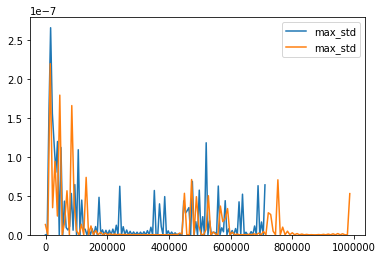

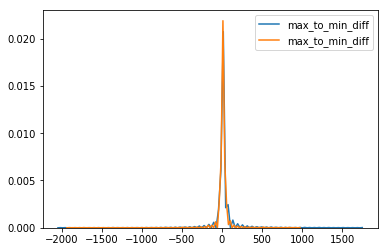

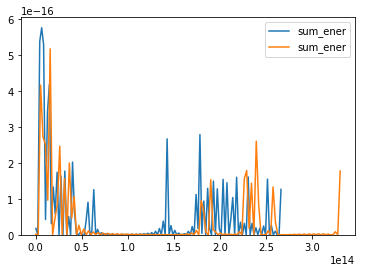

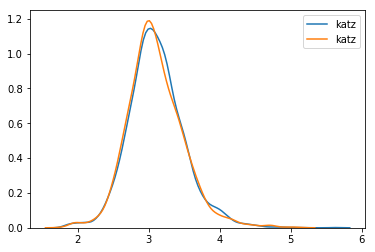

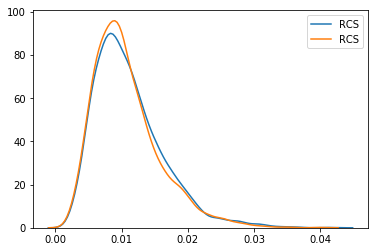

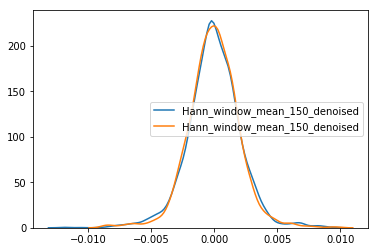

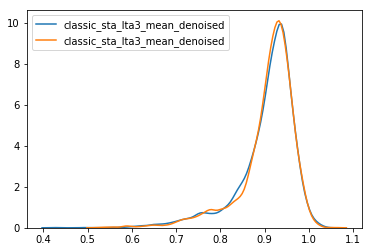

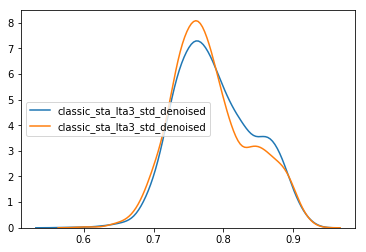

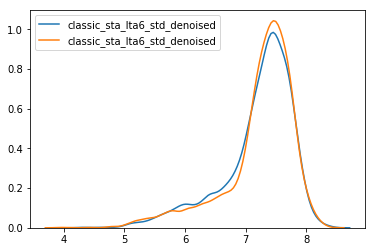

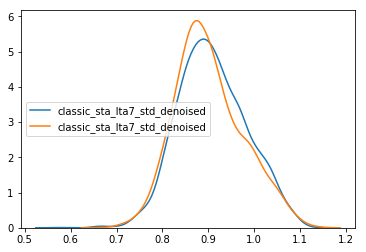

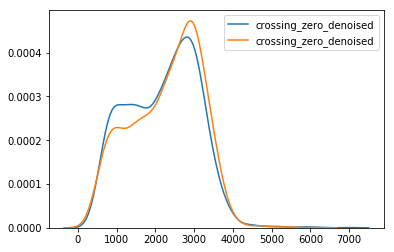

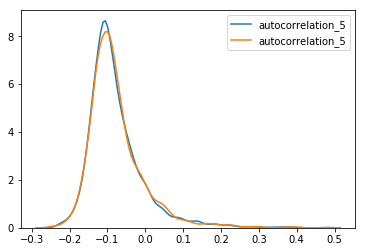

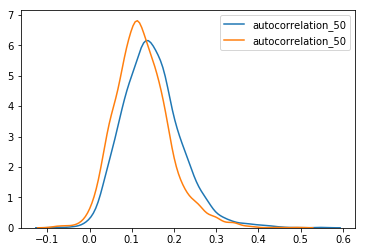

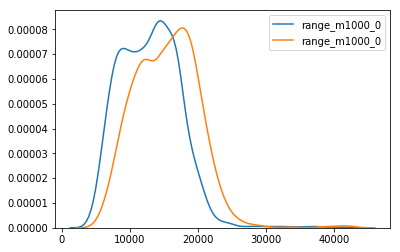

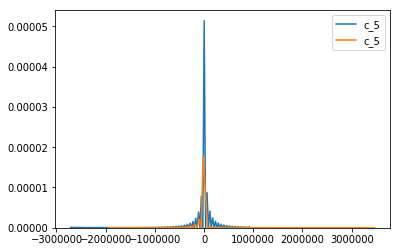

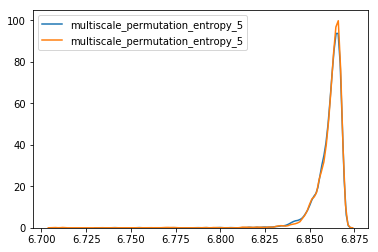

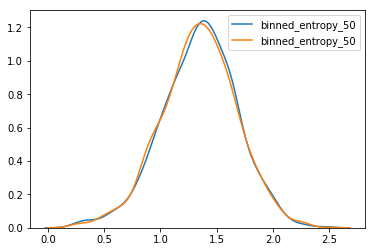

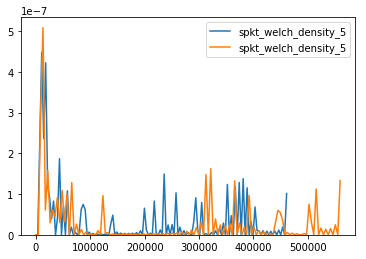

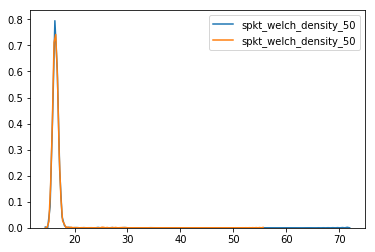

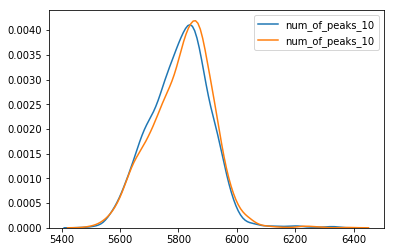

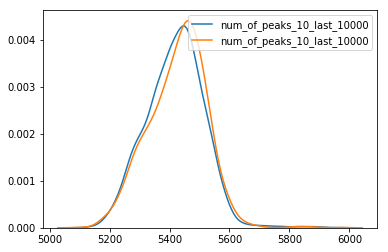

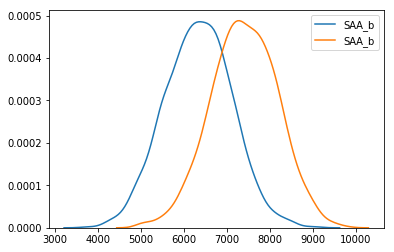

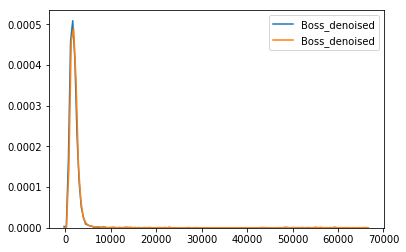

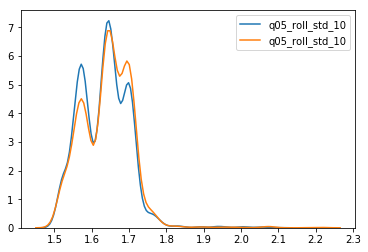

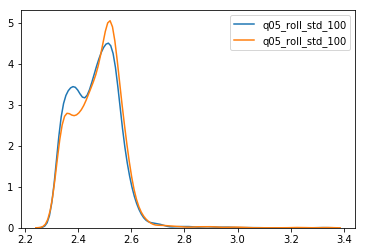

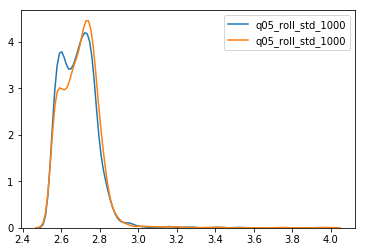

In [136]:
for col in x_train.columns:
    sns.kdeplot(x_train[col])
    sns.kdeplot(x_test[col])
    plt.show()

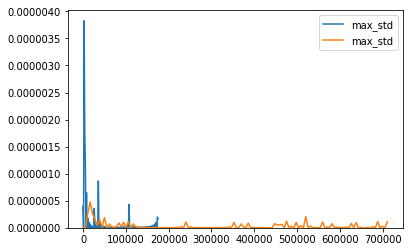

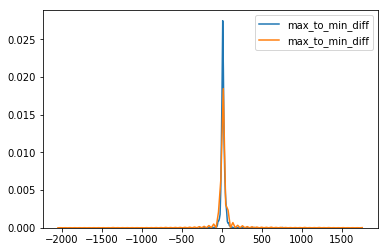

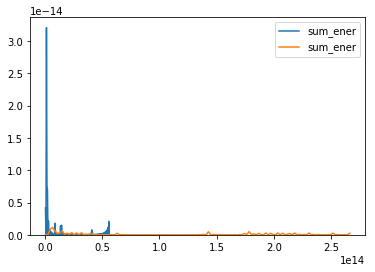

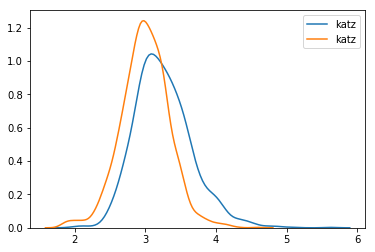

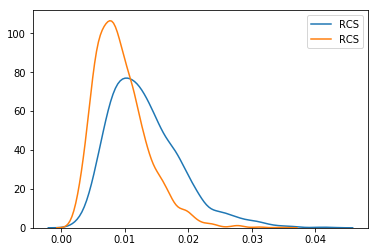

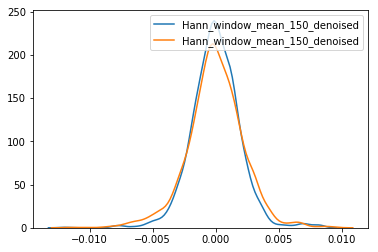

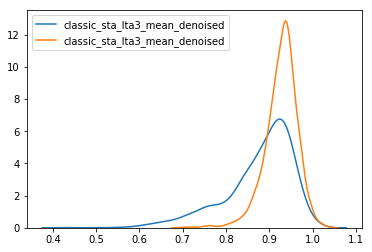

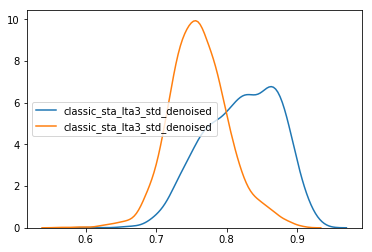

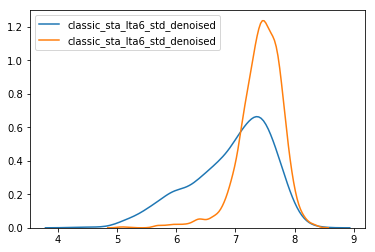

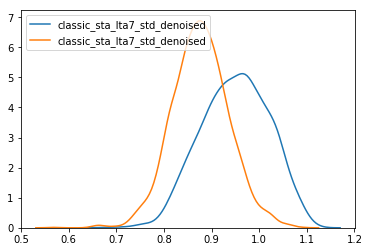

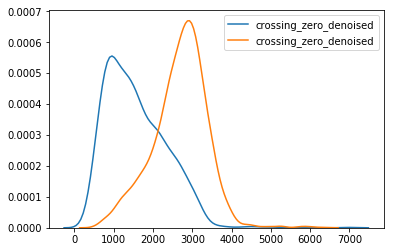

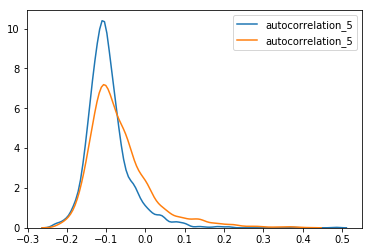

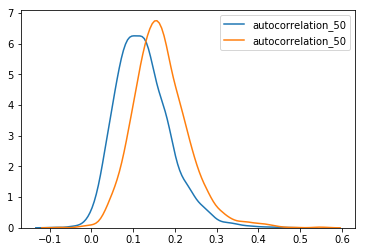

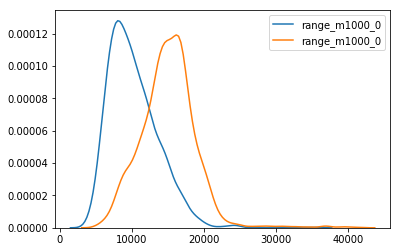

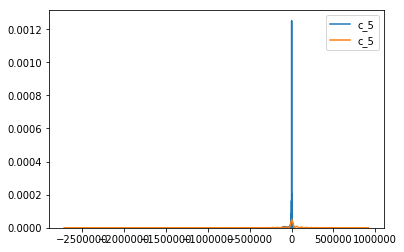

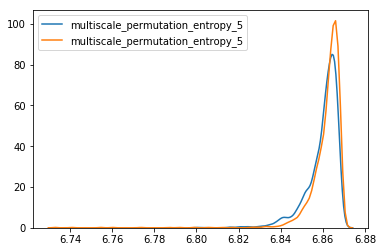

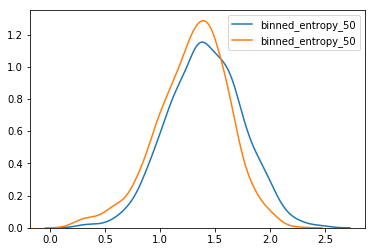

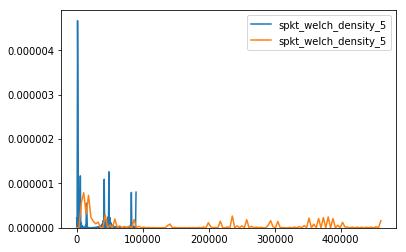

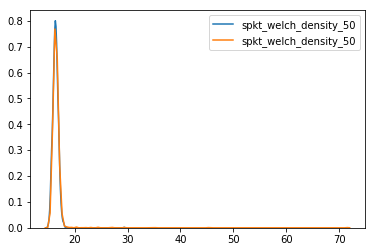

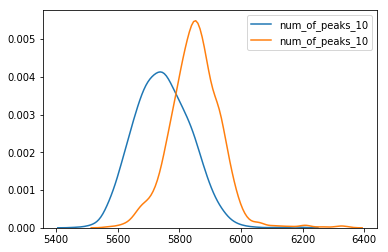

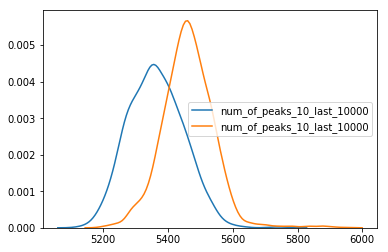

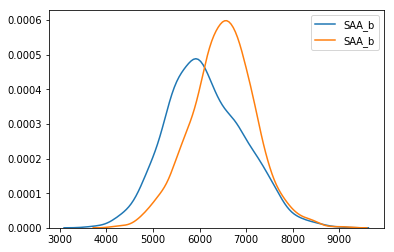

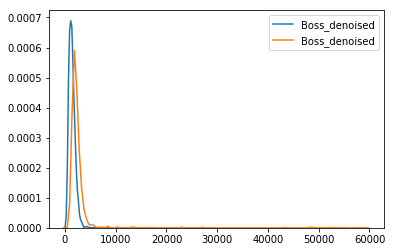

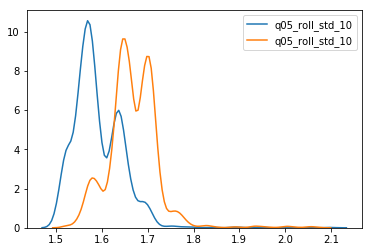

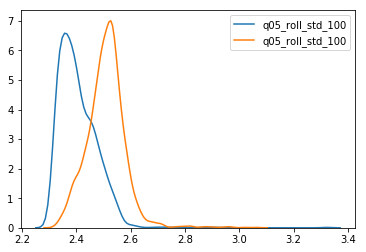

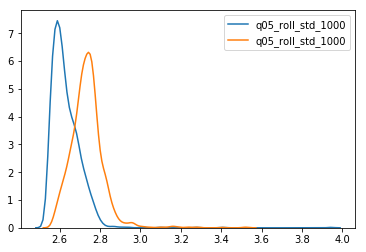

In [137]:
train_high = train_set[train_set['time_to_failure']>6]
train_low = train_set[train_set['time_to_failure']<6]
for col in x_train.columns:
    sns.kdeplot(train_high[col])
    sns.kdeplot(train_low[col])
    plt.show()

In [138]:
print('ready')

ready


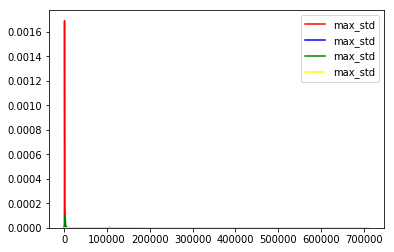

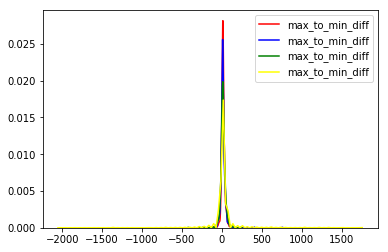

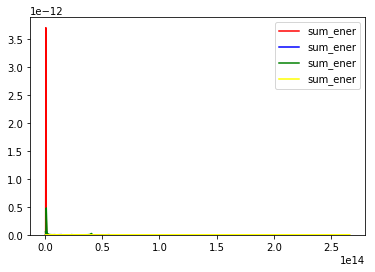

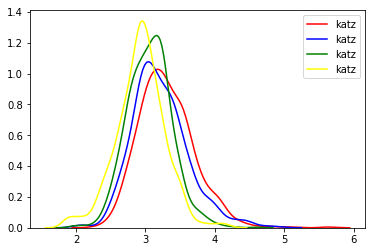

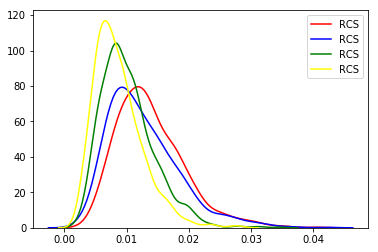

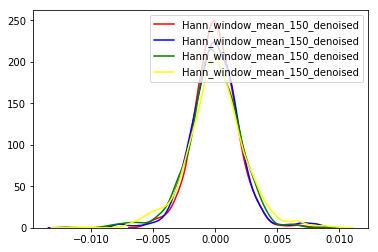

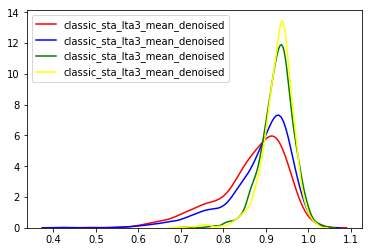

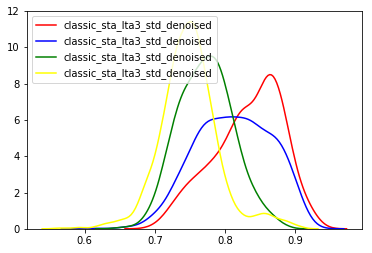

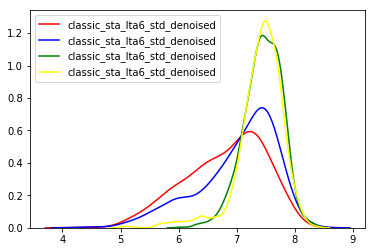

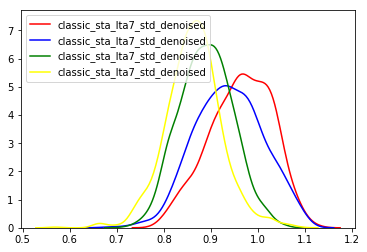

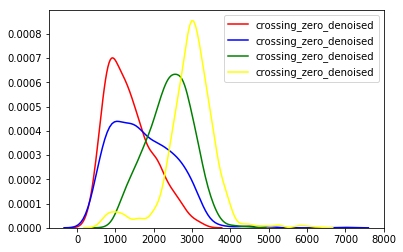

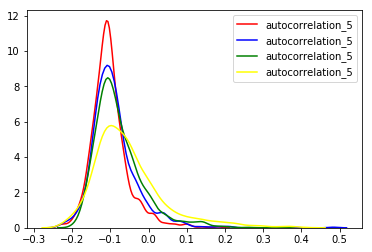

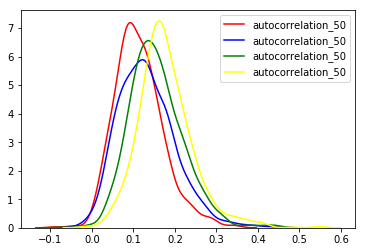

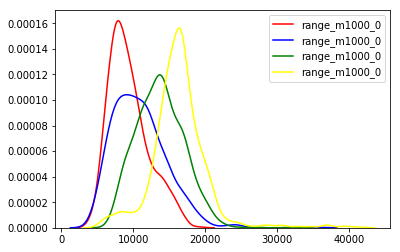

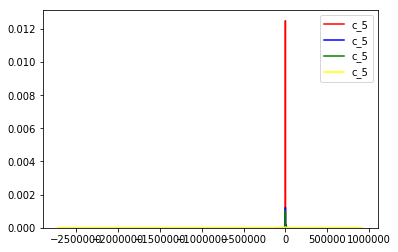

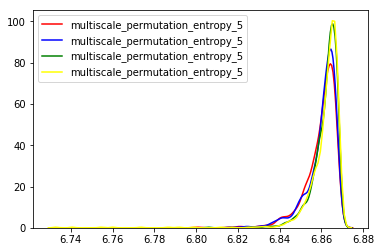

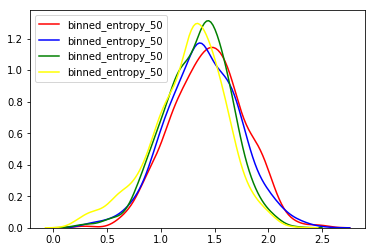

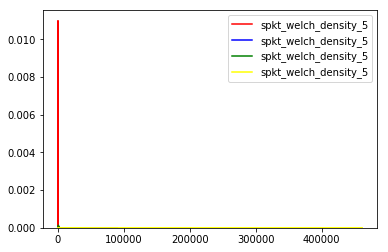

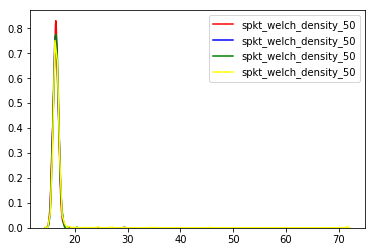

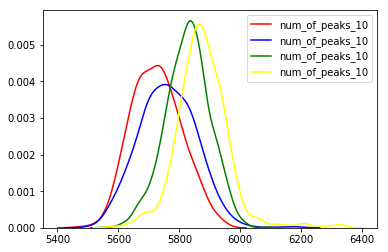

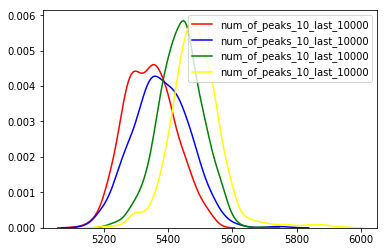

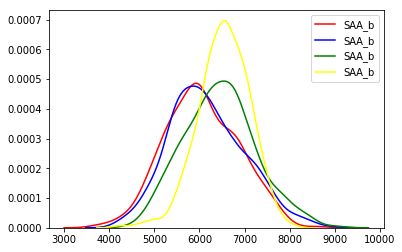

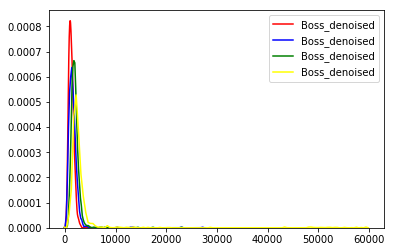

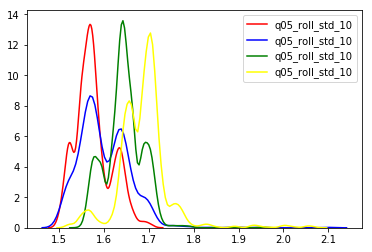

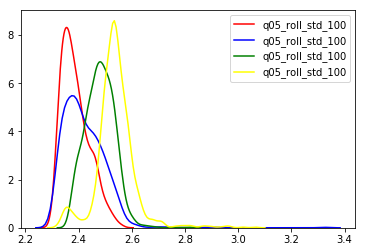

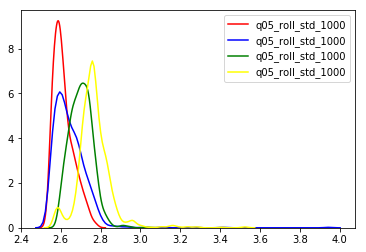

In [139]:
train_cat1 = train_set[train_set['time_to_failure']>9]
train_cat2 = train_set[(train_set['time_to_failure']>6) & (train_set['time_to_failure']<9)]
train_cat3 = train_set[(train_set['time_to_failure']>3) & (train_set['time_to_failure']<6)]
train_cat4 = train_set[(train_set['time_to_failure']>0) & (train_set['time_to_failure']<3)]
for col in x_train.columns:
    sns.kdeplot(train_cat1[col], color='r')
    sns.kdeplot(train_cat2[col], color='blue')
    sns.kdeplot(train_cat3[col], color='green')
    sns.kdeplot(train_cat4[col], color='yellow')
    plt.show()